In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import pandas as pd

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import rc
from matplotlib.colors import ListedColormap
from matplotlib.artist import Artist

In [2]:
# distances
earth_dist = 1.0
mars_dist = 1.52

# hohmann orbit for rover
a = .5*(earth_dist+mars_dist) 
k = 1                                     # years^2 / AU^3
P = np.sqrt(k*a**3)                       # years
P_days = P*365.25                         # days
t_toMars = P_days/2                       # days
mars_moved_day = 360/687                  # degrees / day
mars_moved = mars_moved_day * t_toMars    # degrees
launch_long = 180 - mars_moved            # degrees

# degrees travelled per day
earth_radDay = 2*np.pi/365.25
mars_radDay = 2*np.pi/687

days = 258

# longitude and distance arrays
earth_lon = np.arange(0, earth_radDay*days+earth_radDay, earth_radDay)
mars_lon = np.arange(0, mars_radDay*days+mars_radDay, mars_radDay) + launch_long/360*2*np.pi
earth_dists = np.full(len(earth_lon), earth_dist)
mars_dists = np.full(len(mars_lon), mars_dist)

# complete the orbits to plot as dashed lines
earth_lon_long = np.arange(earth_radDay*days+earth_radDay, 2*np.pi+earth_radDay, earth_radDay)
mars_lon_long = np.arange(mars_radDay*days+mars_radDay, 2*np.pi+mars_radDay, mars_radDay) + launch_long/360*2*np.pi
earth_dists_long = np.full(len(earth_lon_long), earth_dist)
mars_dists_long = np.full(len(mars_lon_long), mars_dist)

# calc rover longitudes and distances - fudge
dist = a - earth_dist
e = dist/a
#b = np.sqrt(a**2 * (1-e**2))
rover_radDay = np.pi/t_toMars   # assuming circle when it's not yikes!
rover_lon = np.arange(0, rover_radDay*days+rover_radDay, rover_radDay)
rover_dists = a*(1-e**2)/(1+e*np.cos(rover_lon))

# set endpoint to be exactly Mars
rover_lon[-1] = mars_lon[-1]
rover_dists[-1] = mars_dist

In [3]:
# scatter func to apply random alphas
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [4]:
# edit plasma colormap to have random alphas!
cmap = plt.cm.plasma
alphas = np.random.rand(cmap.N)/2
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = alphas
my_cmap = ListedColormap(my_cmap)

In [5]:
# rover image to use
path = './mars2020.png'

def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.4) # normally 0.2

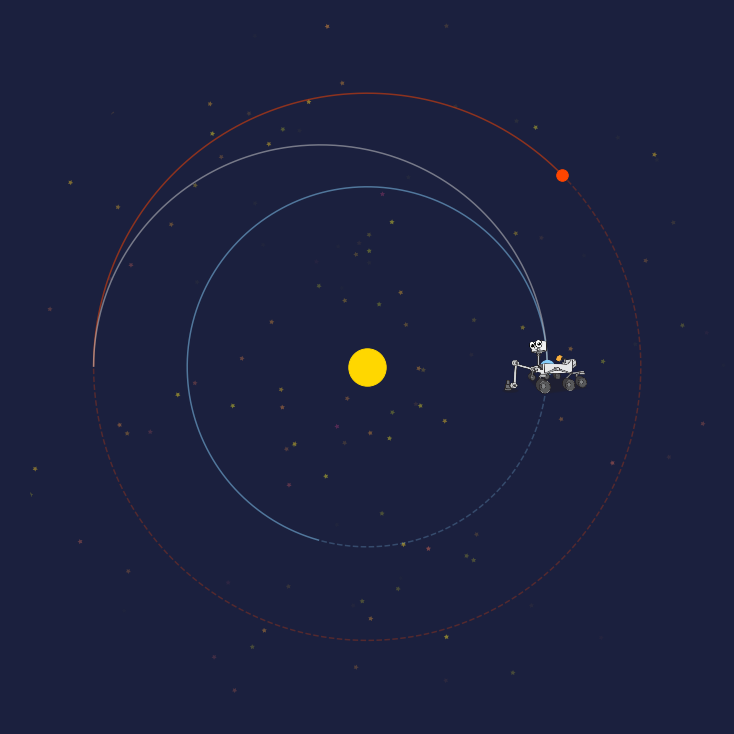

In [10]:
fig = plt.figure(num=1, figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar', label="ax")

# colour background
col_back = '#1B203E'
ax.patch.set_facecolor(col_back)
plt.rcParams["figure.facecolor"] = col_back
plt.rcParams["savefig.facecolor"] = col_back

# background stars
n_stars = 500
s_stars = 30 # normally 5
stars_theta = np.random.rand(n_stars)*360
stars_r = np.random.exponential(2, n_stars)
stars_r = 4 - stars_r
stars_col = np.random.rand(n_stars)
rot = np.random.rand(n_stars)*360
markers = [(5, 1, i) for i in rot]
stars = mscatter(stars_theta, stars_r, s=s_stars, c=stars_col, norm=colors.LogNorm(vmin=stars_col.min(), vmax=stars_col.max()), cmap=my_cmap, m=markers, ax=ax, ec=None)

# initial Mars and Earth pos
i = 0
size = 200  # normally 150
earth = ax.scatter(earth_lon[i], earth_dist, c='lightskyblue', s=size, zorder=2)
mars = ax.scatter(mars_lon[i], mars_dist, c='orangered', s=size*2/3, zorder=2)

# orbit lines
ax.plot(earth_lon, earth_dists, c='lightskyblue', alpha=.5, zorder=1)
ax.plot(mars_lon, mars_dists, c='orangered', alpha=.5, zorder=1)
ax.plot(rover_lon, rover_dists, c='lightgrey', alpha=.5, zorder=1)

ax.plot(earth_lon_long, earth_dists_long, '--', c='lightskyblue', alpha=.25, zorder=0)
ax.plot(mars_lon_long, mars_dists_long, '--', c='orangered', alpha=.25, zorder=0)

# Sun
ax.scatter(0, 0, c='gold', s=[1400], zorder=3)  # normally 1000

# rover initial pos
ab = AnnotationBbox(getImage(path), (rover_lon[i], rover_dists[i]), frameon=False)
rover = ax.add_artist(ab)

ax.set_ylim(0, 2)
ax.axis('off')

# alp = 0.05
# acol = (180/256, 196/256, 206/256, 0.46)
# ax.arrow(0, 0, 0, 1.6, linewidth=2, head_width=0.05, head_length=0.05, color=acol, fc='None', alpha=alp, length_includes_head=False, zorder=-1)
# ax.arrow(np.pi, 0, 0, 1.61, linewidth=2, color=acol, head_width=0.00, head_length=0.00, fc='None', alpha=alp, zorder=-1)
# ax.arrow(np.pi/2, 0, 0, 1.6, linewidth=2, head_width=0.05, head_length=0.05, color=acol, fc='None', alpha=alp, length_includes_head=False, zorder=-1)
# ax.arrow(3*np.pi/2, 0, 0, 1.61, linewidth=2, color=acol, head_width=0.00, head_length=0.00, fc='None', alpha=alp, zorder=-1)

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

def animate(i):
    global rover, earth, mars
#     if i%5 == 0:
#         Artist.remove(rover)
#         ab = AnnotationBbox(getImage(path), (rover_lon[i], rover_dists[i]), frameon=False)
#         rover = ax.add_artist(ab)
    Artist.remove(rover)
    ab = AnnotationBbox(getImage(path), (rover_lon[i], rover_dists[i]), frameon=False)
    rover = ax.add_artist(ab)
    earth.remove()
    mars.remove()
    earth = ax.scatter(earth_lon[i], earth_dist, c='lightskyblue', s=size)
    mars = ax.scatter(mars_lon[i], mars_dist, c='orangered', s=size*2/3)

In [38]:
fig.savefig('test.png', dpi=200)

In [11]:
anim = animation.FuncAnimation(fig, animate, frames=len(earth_lon), interval=50, repeat=True)
anim.save("social.mp4", writer="ffmpeg", fps=60, dpi=200)